# 시작

In [379]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display

# 데이터 불러오기 & 확인 & 전처리

In [390]:
C_PATH = os.getenv('HOME') + '/aiffel/dcgan_newimage/fashion'

def load_lms_data():
    (train_x,_), (test_x,_) = tf.keras.datasets.fashion_mnist.load_data()
    train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
    return train_x, test_x
    
def load_data():
    (train_x,_), (test_x,_) = tf.keras.datasets.cifar10.load_data()
    print('{}개 훈련 데이터, {}개 시험 데이터를 불러왔습니다'.format(len(train_x), len((test_x))))
    print('훈련데이터: {}'.format(train_x.shape))
    print('시험데이터: {}'.format(test_x.shape))
    return train_x, test_x


def preprocess_data(data):
    '''
    입력 데이터를 -1~1의 값으로 수정한다
    '''
    '''
    mean = np.mean(data, axis=tuple(range(data.ndim-1)))
    mean = np.expand_dims(mean, axis=0)
    std = np.std(data, axis=tuple())
    data = (data-mean)/std
    '''
    data = (data-127.5)/127.5
    #data = data/255
    return data


def draw_data(data, row=5, col=5):
    '''
    데이터 원본을 무작위로 row*col갯수만큼 그린다
    '''
    plt.figure(figsize=(10,10))
    for i in range(row*col):
        plt.subplot(row, col, i+1)
        n = np.random.randint(data.shape[0])
        plt.imshow(data[n])
        plt.axis('off')
    plt.show()

# 모델 생성

In [381]:
INPUT_SIZE = 100

In [397]:
def make_lms_generator_model():
    '''
    LMS 생성자 모델
    '''
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(INPUT_SIZE,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


def make_lms_discriminator_model():
    '''
    LMS 판별자 모델
    '''
    model = tf.keras.Sequential()
    
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    '''
    model.add(layers.Conv2D(3*64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    '''
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [383]:
def make_generator_model():
    '''
    생성자 모델
    '''
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(INPUT_SIZE,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    '''
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    '''
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 32, 32, 3)

    return model


def make_discriminator_model():
    '''
    판별자 모델
    '''
    model = tf.keras.Sequential()
    
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    '''
    model.add(layers.Conv2D(3*64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    '''
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# 모델 훈련

In [384]:
BATCH_SIZE = 256

In [402]:
LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(fake):
    return LOSS(tf.ones_like(fake), fake)


def discriminator_loss(real, fake):
    fake_loss = LOSS(tf.zeros_like(fake), fake)
    real_loss = LOSS(tf.ones_like(real), real)
    return fake_loss+real_loss


def discriminator_accuracy(real, fake):
    base = tf.constant([0.5])
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake, base), tf.float32))
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real, base), tf.float32))
    return real_accuracy, fake_accuracy


@tf.function
def train_step(generator, discriminator, real_images):
    noise = tf.random.normal([BATCH_SIZE, INPUT_SIZE])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        fake_images = generator(noise, training=True)
        
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)
        
        real_acc, fake_acc = discriminator_accuracy(real_output, fake_output)
    
    gen_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    dis_gradient = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gen_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(dis_gradient, discriminator.trainable_variables))
    
    return gen_loss, dis_loss, real_acc, fake_acc

# 시각화 & 저장

In [386]:
def draw_samples(samples, row=4, col=4, file=None):
    '''
    생성된 이미지를 그린다
    file(str)이 있다면 파일에 저장한다
    '''
    plt.figure(figsize=(10,10))
    for i in range(row*col):
        plt.subplot(row, col, i+1)
        plt.imshow(samples[i])
        plt.axis('off')
    if file:
        path = os.path.join(C_PATH, 'generated_samples')
        plt.savefig(os.path.join(path, file))
    plt.show()
    
    
def draw_train_history(history, file=None):  
    '''
    학습 과정을 그린다
    file(str)이 있다면 파일에 저장한다
    '''
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['dis_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'dis_loss'], loc='upper left')  

    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    if file:
        path = os.path.join(C_PATH, 'training_history')
        plt.savefig(os.path.join(path, file))
    plt.show()

# 최종 사용 함수

In [387]:
def train(generator, discriminator, dataset, epochs, seed):
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

    history = {'gen_loss':[],'dis_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)
    for epoch in range(epochs):
        for i, images in enumerate(dataset):
            gen_loss, dis_loss, real_acc, fake_acc = train_step(generator, discriminator, images)
            history['gen_loss'].append(gen_loss)
            history['dis_loss'].append(dis_loss)
            history['real_accuracy'].append(real_acc)
            history['fake_accuracy'].append(fake_acc)
            if (i%50)==0:
                display.clear_output(wait=True)
                g_image = generator(seed, training=False)
                #image_file = 'sample_e{}_i{}'.format(epoch, i)
                draw_images(g_image)
        if (epoch + 1) % 5 == 0:
            path = os.path.join(C_PATH, 'training_checkpoints')
            checkpoint.save(file_prefix=os.path.join(path, 'ckpt'))
        # history_file = 'history_e{}'.format(epoch)
        draw_train_history(history)

In [388]:
train_x, test_x = load_lms_data()

In [370]:
train_x, test_x = load_data()

50000개 훈련 데이터, 10000개 시험 데이터를 불러왔습니다
훈련데이터: (50000, 32, 32, 3)
시험데이터: (10000, 32, 32, 3)


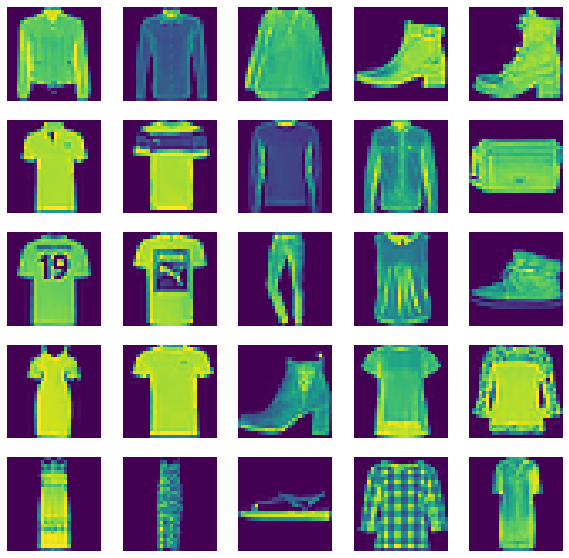

In [389]:
draw_data(train_x)

In [391]:
train_x = preprocess_data(train_x)

In [392]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(train_x.shape[0]).batch(BATCH_SIZE)

In [398]:
generator = make_lms_generator_model()
generator.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_133 (Bat (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_164 (LeakyReLU)  (None, 12544)             0         
_________________________________________________________________
reshape_44 (Reshape)         (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_132 (Conv2D (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_134 (Bat (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_165 (LeakyReLU)  (None, 7, 7, 128)       

In [399]:
discriminator = make_lms_discriminator_model()
discriminator.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_167 (LeakyReLU)  (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_168 (LeakyReLU)  (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 6272)            

In [400]:
NUM_PIC = 16
seed = tf.random.normal([NUM_PIC, INPUT_SIZE])
seed.shape

TensorShape([16, 100])

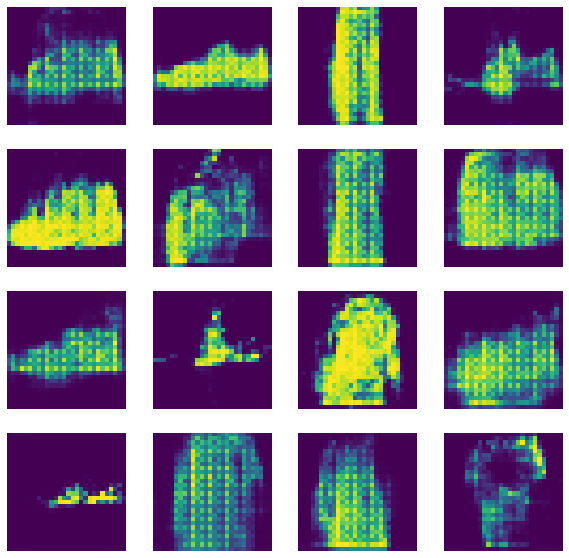

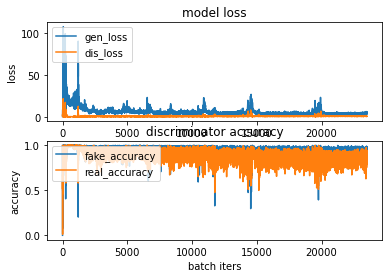

In [403]:
train(generator, discriminator, train_dataset, 100, seed)